# Doc2vec training and vectorisarion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
from wordfreq import top_n_list
import numpy as np
from nltk.corpus import stopwords
import requests
import requests_random_user_agent
from tqdm.notebook import tqdm
from nltk.stem import PorterStemmer
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import glob
from gensim.test.utils import datapath
import logging
import random
from random import sample
random.seed(1)
from fpdf import FPDF
from IPython.display import clear_output
import time

In [3]:
#import functions from functions.py
from function_definitions import *

## Tokenization

In [4]:
#tokenize MITRE Tactics by sub-techniques
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
tac_tokens = []
cols = []
for type_ in tqdm(tactic_types, desc = 'Tokenizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0,1])
    technique = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.droplevel('technique').itertuples():
        tac_tokens.append(pd.DataFrame(get_tokens(tactic, raw = False, merge = False, sentences = False)[0]))
        cols.append(technique +'__'+sub_technique)
tac_tokens = pd.concat(tac_tokens, axis = 1).fillna(np.nan)
tac_tokens.columns = cols

Tokenizing Tactics:   0%|          | 0/14 [00:00<?, ?it/s]

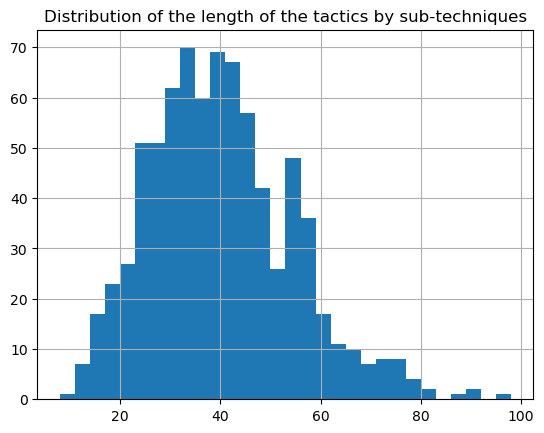

mean = 39.73375796178344


In [5]:
#plot the distribution of the length of sub-techniques
len_tac = (~tac_tokens.isnull()).sum()
len_tac.hist(bins = 30)
plt.title('Distribution of the length of the tactics by sub-techniques')
plt.show()
print('mean = {}'.format(len_tac.mean()))

In [4]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [46]:
#tokenize each sentence of each 10-K statements and save the resulting tockens
save_path = '../data/10k_statements/tokens/'
years = np.arange(2007,2023)

common_words = top_n_list('en', 100)
stop_words = stopwords.words('english')
alphabet = re.compile('[^a-z]')

delayed_tokens = dask.delayed(get_tokens)

for year in years[10:]:
    #take the urls of all the 10-K fillings for each year
    urls = stocknames.filter(like = 'url_{}'.format(year))
    urls.index = stocknames.ticker
    urls = urls.dropna()
    
    #compute in batches
    len_batch = 250
    #ceil of euclidian division
    nb_batches = -(len(urls) // -len_batch)
    start = 0
    end = len_batch
    for batch in tqdm(range(nb_batches), desc = 'Tokenizing 10-Ks for {}'.format(year),
                     leave = False):
        #get a list of tokens for each sentence of each document
        allpromises = []
        for ticker, url in urls.iloc[start:end,:].itertuples():
            text = requests.get(url).text
            allpromises.append(delayed_tokens(text, ticker = ticker))

        with TqdmCallback(desc = 'Tokenizing 10-Ks in batch', leave = False):
            tokens = dask.compute(allpromises)[0]

        #save the tokens
        for dict_ in tokens:
            ticker = list(dict_.keys())[0]
            tokens_df = pd.DataFrame(dict_[ticker])
            tokens_df.to_csv(save_path+'{}/{}_tokens.csv.gz'.format(year, ticker))
        
        start += len_batch
        end += len_batch
    time.sleep(120)
    
clear_output()
print('Done')

Done


In [87]:
token_path = '../data/10k_statements/tokens/{}/*'
#print summary statictics of the paragraphs from the 10-Ks
stats = []
index = []
for year in years:
    files = glob.glob(token_path.format(year))
    allpromises = []
    for file in files:
        allpromises.append(get_token_stats(file))
        ticker = re.findall('\d/(.*)_tokens.csv.gz', file)[0]
        index.extend([ticker+'_'+str(year)])
        
    with TqdmCallback(desc = 'Computing stats on tokens for {}'.format(year), leave = False):
        stats.extend(dask.compute(allpromises)[0])
        
clear_output()
pd.DataFrame(stats, columns = ['nb_paragraphs', 'avg_paragraph_len'], index = index).dropna().describe()

,nb_paragraphs,avg_paragraph_len
count,60469.000000,60469.000000
mean,638.036713,44.889974
std,303.869567,2.633300
min,1.000000,10.000000
25%,448.000000,43.070270
50%,603.000000,44.175610
75%,780.000000,46.167910
max,5036.000000,89.954787


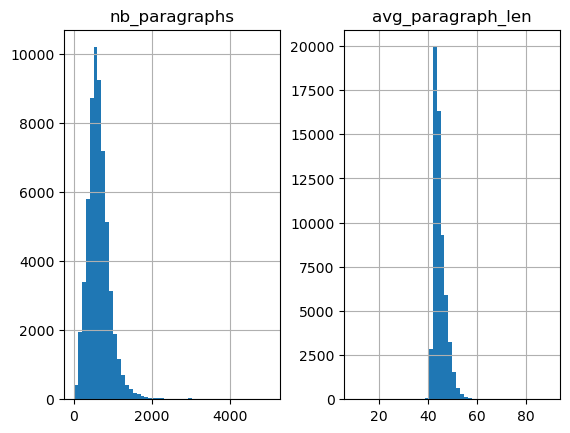

In [88]:
pd.DataFrame(stats, columns = ['nb_paragraphs', 'avg_paragraph_len'], index = index).dropna().hist(bins = 50)
plt.show()

## Training

In [4]:
# train several models: 
#       baseline: DBOW, vsize 100
#       change type to DM
#       make vsize 200/300
#       more/less epochs

# compare models on a "validation set" (= a few out of sampe 10-Ks)

In [5]:
#read in the tokens from the 10-K statements
training_years = [2007]
tokens_10k = []
for year in training_years:
    path_tokens = glob.glob('../data/10k_statements/tokens/{}/*'.format(year))
    for path in tqdm(path_tokens, desc = 'Reading in tokens for {}'.format(year), leave = False):
        df = pd.read_csv(path, index_col = 0, dtype = 'object')
        tokens = df.stack().groupby(level = 0).agg(list).values
        ticker = re.findall('{}/(.*)_tokens'.format(year),path)[0]
        tokens_10k.append(tokens)

#add a tag to each paragraph
tagged_tokens = []
tag_links = []
training_tokens = []
for i, tokens_per_line in enumerate(tqdm(tokens_10k, desc = 'Adding tags to 10-Ks', leave = False)):
    for j, tokens in enumerate(tokens_per_line):
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['10kt{}_{}'.format(i,j)]))
        tag_links.append('10kt{}_{}'.format(i,j))
        training_tokens.append(tokens)

print('Nb training paragraphs from 10-Ks: {}'.format(len(tagged_tokens))) 

#add MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
for i,type_ in enumerate(tqdm(tactic_types, desc = 'Adding Tactics', leave = False)):
    tactics = pd.read_csv(type_, index_col = [0,1])
    for j,tactic in enumerate(tactics.Description.values):
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['tac{}_{}'.format(i,j)]))
        tag_links.append('tac{}_{}'.format(i,j))
        training_tokens.append(tokens)

print('Nb training paragraphs: {}'.format(len(tagged_tokens)))

#this dataframe links the numerical index of each training sentence to it's tag
pd.DataFrame(tag_links, columns = ['tag']).to_csv('../data/index_to_tags.csv')

Reading in tokens for 2007:   0%|          | 0/3301 [00:00<?, ?it/s]

Adding tags to 10-Ks:   0%|          | 0/3301 [00:00<?, ?it/s]

Nb training paragraphs from 10-Ks: 1747928


Adding Tactics:   0%|          | 0/14 [00:00<?, ?it/s]

Nb training paragraphs: 1748713


In [6]:
#usefull to show the logs when training the model
logging.disable(logging.NOTSET)
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

In [7]:
models = ['model_dbow_v100_e20_w15','model_dm_v100_e20_w15','model_dbow_v200_e20_w15',
          'model_dbow_v100_e10_w15','model_dbow_v100_e50_w15', 'model_dbow_v300_e20_w15',
          'model_dbow_v100_e30_w15','model_dbow_v100_e20_w10', 'model_dbow_v100_e20_w30',
          'model_dbow_v200_e50_w15']

for model_ in models:
    v_size = int(re.findall('v(\d+)', model_)[0])
    epochs = int(re.findall('e(\d+)', model_)[0])
    dm = int(bool(re.search('dm', model_)))
    window = int(re.findall('w(\d+)', model_)[0])
    
    #define the model and vocabulary
    model = gensim.models.doc2vec.Doc2Vec(vector_size = v_size, min_count = 5, epochs = epochs, sample = 1e-5,
                                          negative = 5, dm = dm, window = window)
    model.build_vocab(tagged_tokens)
    
    #train the model
    model.random.seed(0)
    model.train(tagged_tokens, total_examples = model.corpus_count, epochs = model.epochs)
    
    #save the model
    path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/{}'.format(model_))
    model.save(path)
    
    time.sleep(120)
    clear_output()

## Choose the best model 

In [ ]:
#cybersecurity score:
#want to take the average score of the most cybersecurity related paragraphs
#-> take 1% most cybersecurity related paragraphs and compute their average score

#overall cybersecurity score:
#start with similarity between each paragraph and tactic
#the score of a paragraph is the maximum similarity to a tactic
#now you have a single score for each paragraph
#take mean of the scores above the 99th percentile of scores

#cybersecurity score per tactic:
#start with similarity between each paragraph and tactic
#the score of a paragraph is the similarity to the tactic that is considered
#now you have a single score for each paragraph
#take mean of the scores above the 99th percentile of scores

In [17]:
#disable logging while using the models 
logging.disable()
models = ['model_dbow_v100_e20_w15','model_dm_v100_e20_w15','model_dbow_v200_e20_w15',
          'model_dbow_v300_e20_w15','model_dbow_v100_e10_w15','model_dbow_v100_e30_w15',
          'model_dbow_v100_e50_w15','model_dbow_v100_e20_w10','model_dbow_v100_e20_w30',
          'model_dbow_v200_e50_w15']

#use ten 10-Ks from 2008 chosen at random
token_path = '../data/10k_statements/tokens/{}/*'
random.seed(1)
files = sample(glob.glob(token_path.format(2008)),10)

pdf = FPDF() #the highest scoring paragraphs for each model are printed on a separate pdf file
recap = []
cyber_risk_scores = {}
for model_ in tqdm(models, desc = 'Comparing models'):
    #load the previously saved model
    path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/'+model_)
    model = gensim.models.doc2vec.Doc2Vec.load(path)

    #get vectors of MITRE Tactics
    tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
    vec_tac = []
    type_table = []
    len_table = []
    link_table = []
    for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
        tactics = pd.read_csv(type_, index_col = [0,1])
        name = re.findall('tactics_([^\.]+)',type_)[0]
        for sub_technique,tactic in tactics.droplevel('technique').itertuples():
            tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
            vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
            link_table.append('{}__{}'.format(name,sub_technique))
            len_table.append(len(tokens))
            type_table.append(name)

    pdf.add_page()
    pdf.set_font("Arial", size = 25)
    pdf.cell(200, 10, txt= model_, ln=1)
    
    cyber_risk_scores[model_] = []
    most_sim_paragraphs = []
    most_sim_paragraphs_scores = []
    most_sim_paragraphs_most_sim_tactic = []
    tickers = []
    
    for i,file in enumerate(files):
        ticker = re.findall('\d/(.*)_tokens.csv.gz', file)[0]
        tockens = pd.read_csv(file, index_col = 0, dtype = 'object').T
        
        #compute vector representations for all the paragraphs
        vects = []
        paragraphs = []
        for j, col in enumerate(tockens.columns):
            v,p = get_vect(model, tockens[col].dropna().values, '10ktest{}_{}'.format(i,j), words = True)
            vects.append(v)
            paragraphs.append(p)

        allpromises = []
        for v in vects:
            allpromises.append(get_sim(v,vec_tac))

        with TqdmCallback( leave = False):
            sim = dask.compute(allpromises)[0]
        
        #save the scores (= mean score above 99th percentile of scores of the paragraphs)
        max_ = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph
        document_score = np.mean(max_[max_> np.percentile(max_, 99)])
        recap.append([ticker, model_, document_score])
        #get a score for each type of cybersecurity event
        type_table = np.array(type_table)
        sim = np.array(sim)
        for type_ in np.unique(type_table):
            #get the score for the tactic
            max_by_tactic = np.max(sim[:,type_table == type_], axis = 1)
            document_tactic_score = np.mean(max_by_tactic[max_by_tactic> np.percentile(max_by_tactic, 99)])
            cyber_risk_scores[model_].append([ticker, type_, document_tactic_score])
        
        #save the highest scoreing paragraphs
        nb_para = 10
        highest_score_idxs = np.argsort(max_)[-nb_para:] #= idx of the paragraphs with highest max sim to tactics
        most_sim_paragraphs.extend([' '.join(paragraphs[idx]) for idx in highest_score_idxs])
        most_sim_paragraphs_scores.extend([max_[idx]for idx in highest_score_idxs])
        idx_most_sim_tactics = np.argmax(sim, axis = 1)#= idx of the tactic each paragraph is most similar to
        most_sim_paragraphs_most_sim_tactic.extend(
            [link_table[idx] for idx in idx_most_sim_tactics[highest_score_idxs]])
        tickers.extend([ticker]*nb_para)
    
    #print the highest scoring paragraphs on the pdf for each model
    pdf.add_page()
    pdf.set_font("Arial", size = 20)
    pdf.cell(200, 10, txt='The highest scoring paragraphs are:', ln=1)
    pdf.set_font("Arial", size=12)
    for idx in reversed(np.argsort(most_sim_paragraphs_scores)):
        txt_ = 'from '+ str(tickers[idx])+', score: '+str(round(most_sim_paragraphs_scores[idx],3))
        txt_ += ' similar to '+ str(most_sim_paragraphs_most_sim_tactic[idx])
        pdf.cell(200, 4, txt = txt_, ln=1)
        pdf.multi_cell(190, 4, txt = most_sim_paragraphs[idx])
        pdf.ln()
        
        
pdf_path = '../models/comparison/model_comparison.pdf'
pdf.output(pdf_path)
clear_output()
print('Done')

recap = pd.DataFrame(recap, columns = ['ticker', 'model', 'score'])
recap = recap.pivot(index = 'model', columns = 'ticker', values = 'score')
recap.columns.name = None
recap.loc[models,:]

Done


,CSCD,GTLS,LXRX,MDAS,PBY,PZZA,UMH,VALU,VSTY,VXRT
model,,,,,,,,,,
model_dbow_v100_e20_w15,0.660084,0.613592,0.672883,0.657608,0.579468,0.604327,0.578187,0.632024,0.710307,0.648099
model_dm_v100_e20_w15,0.977408,0.972749,0.975854,0.975223,0.975656,0.970953,0.973598,0.971350,0.974692,0.976863
model_dbow_v200_e20_w15,0.623255,0.583523,0.638875,0.618699,0.554009,0.547740,0.567526,0.604895,0.656818,0.598785
model_dbow_v300_e20_w15,0.610529,0.588446,0.620462,0.611210,0.545198,0.528426,0.555193,0.582028,0.651263,0.601793
model_dbow_v100_e10_w15,0.857278,0.808131,0.827724,0.828284,0.753463,0.749867,0.751280,0.812655,0.835025,0.819433
model_dbow_v100_e30_w15,0.613217,0.582050,0.640818,0.637702,0.569752,0.564578,0.554576,0.623615,0.682945,0.586673
model_dbow_v100_e50_w15,0.594894,0.554994,0.610980,0.603419,0.532155,0.532819,0.524418,0.616923,0.629863,0.600465
model_dbow_v100_e20_w10,0.664675,0.613829,0.672240,0.663857,0.580412,0.580285,0.576639,0.623110,0.709349,0.642637
model_dbow_v100_e20_w30,0.653522,0.623131,0.660344,0.661980,0.600851,0.590601,0.594389,0.616548,0.691016,0.638649


In [ ]:
plt.figure()
plt.hist(max_, bins = 100)
plt.title('Distribution of the maximum similarity for each sentence of the 10-K')
plot_path = '../models/comparison/plots/max_{}_{}.png'.format(ticker,model_)
plt.savefig(plot_path)
pdf.image(plot_path, w = 200)
plt.close()

In [18]:
recap.loc[models,:].std(1)

model
model_dbow_v100_e20_w15    0.042339
model_dm_v100_e20_w15      0.002214
model_dbow_v200_e20_w15    0.036246
model_dbow_v300_e20_w15    0.037660
model_dbow_v100_e10_w15    0.038797
model_dbow_v100_e30_w15    0.040988
model_dbow_v100_e50_w15    0.039761
model_dbow_v100_e20_w10    0.045464
model_dbow_v100_e20_w30    0.033494
model_dbow_v200_e50_w15    0.030458
dtype: float64

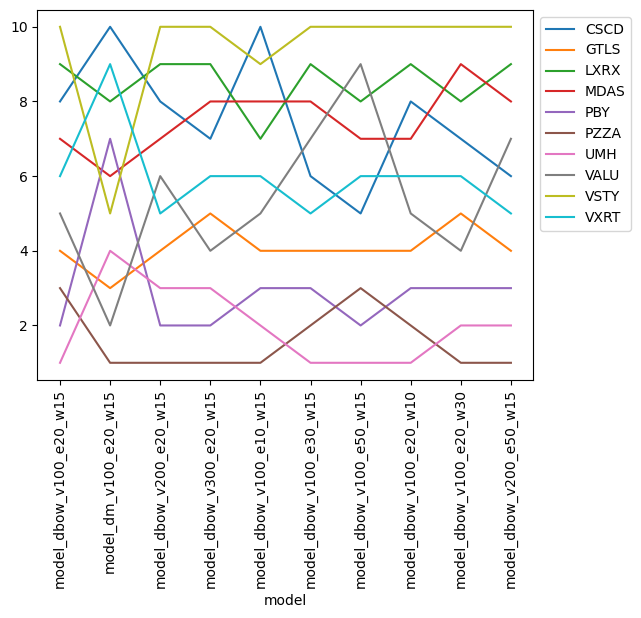

In [19]:
#plot the ranking of firms for each model
# 10=firm with highest cybersecurity score and 1 = firm with lowest cybersecurity score
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff33cc', '#6600cc']
recap.rank(1).loc[models,:].plot(color = color_list)
plt.legend(bbox_to_anchor = (1,1))
plt.xticks(np.arange(0,len(models)),models, rotation = 90)
plt.show()

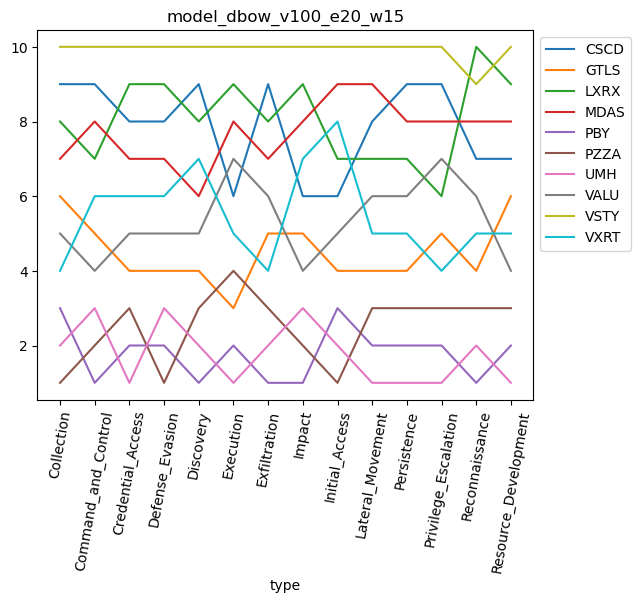

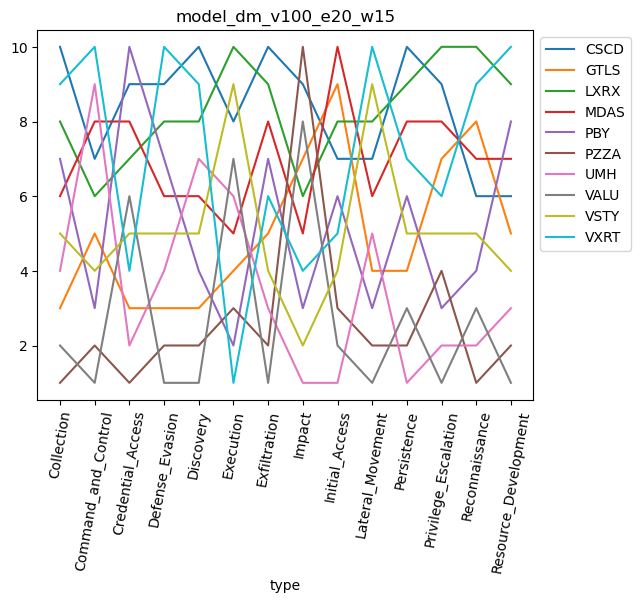

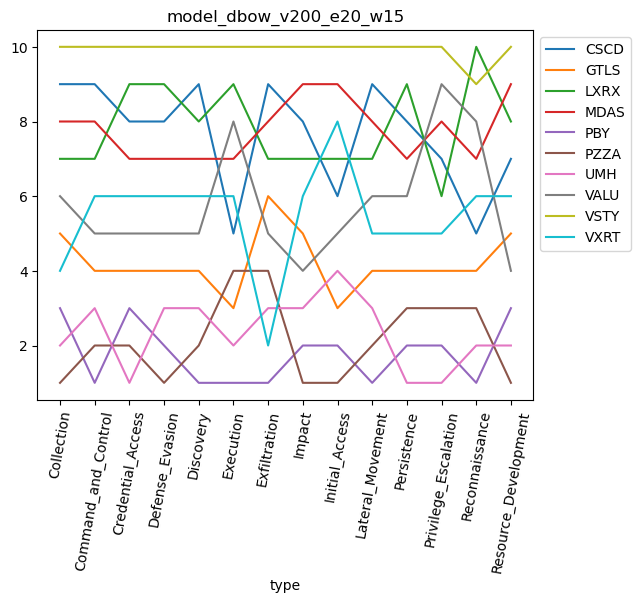

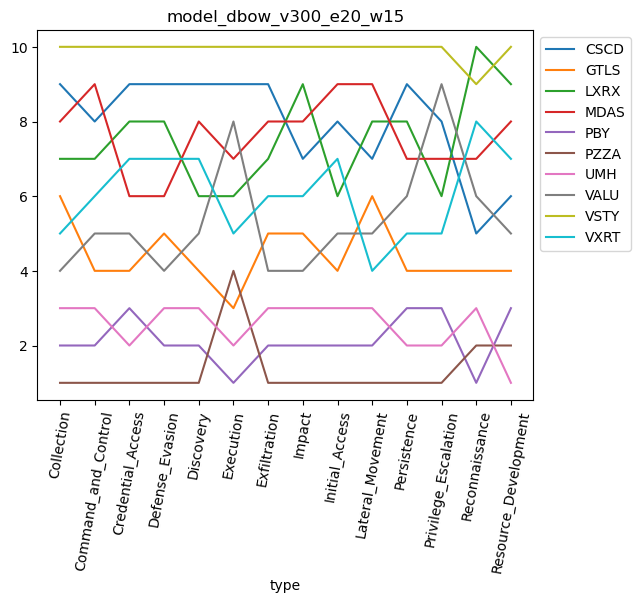

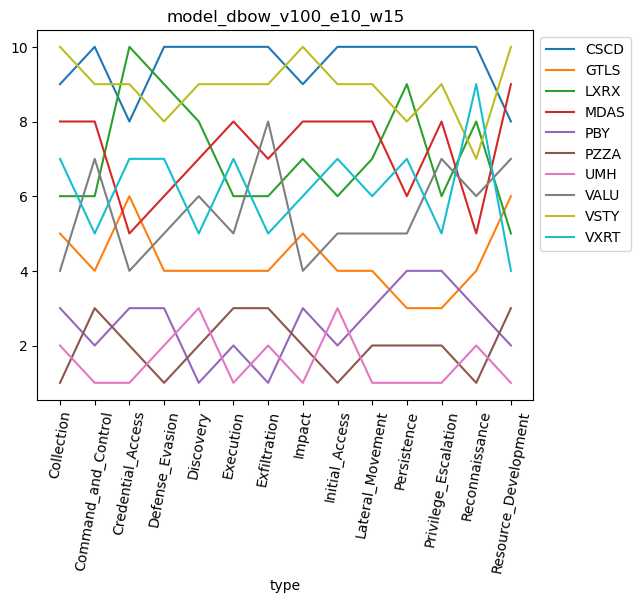

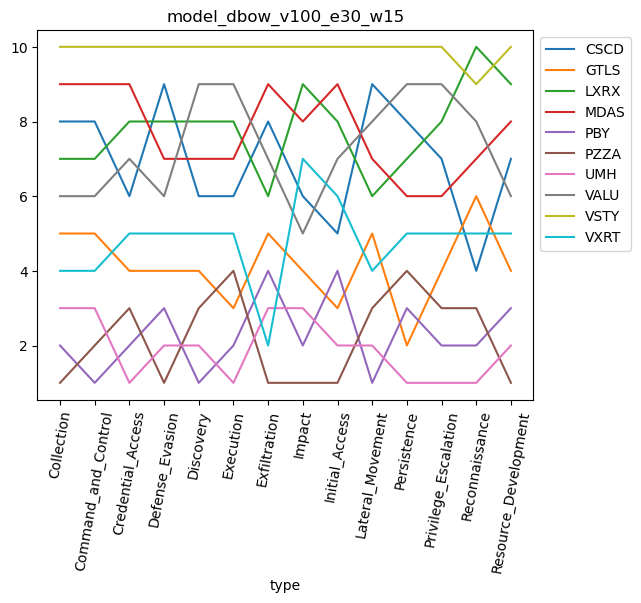

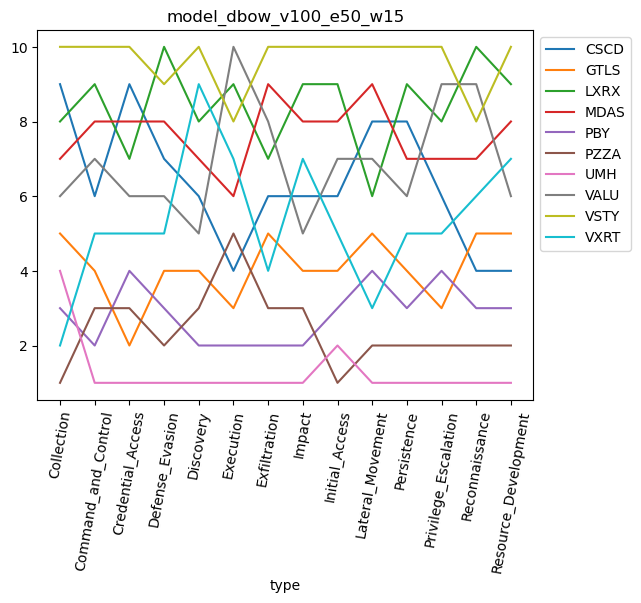

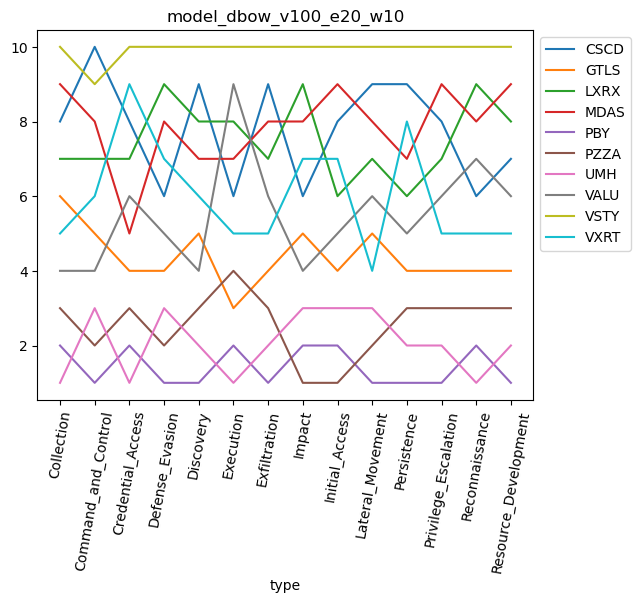

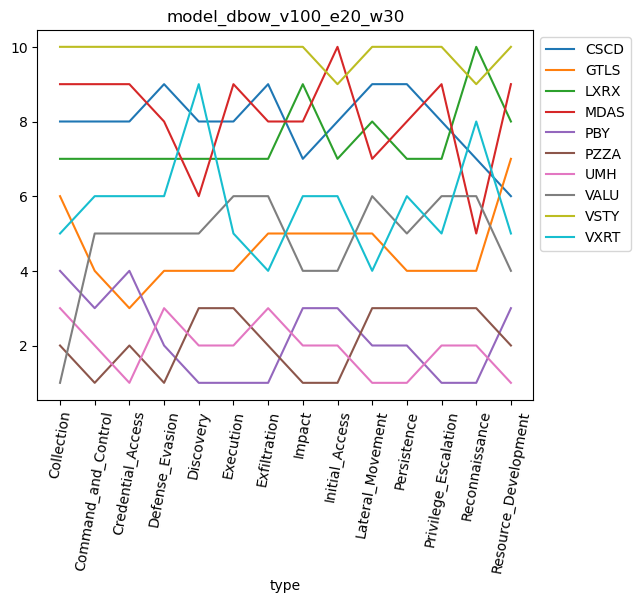

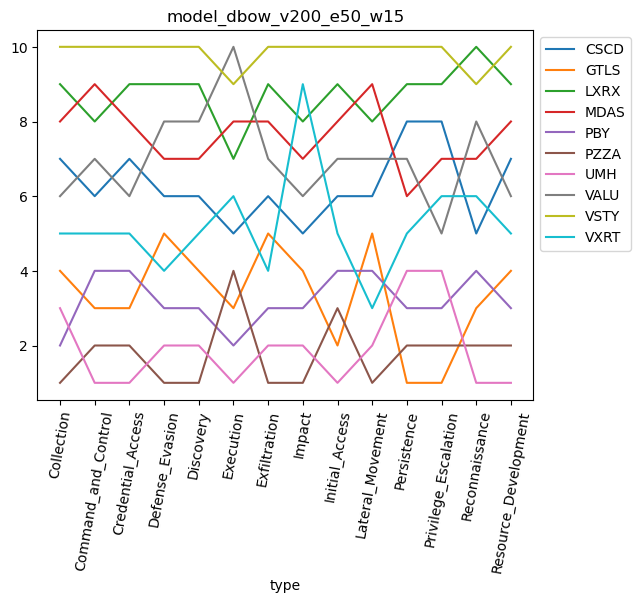

In [20]:
#plot the ranking of firms for each model and each type of cybersecurity tactic
for model_,cyber_risk in cyber_risk_scores.items():
    cyber_risk = pd.DataFrame(cyber_risk, columns = ['ticker', 'type', 'score'])
    cyber_risk = cyber_risk.pivot(index = 'type', columns = 'ticker', values = 'score')
    cyber_risk.columns.name = None
    cyber_risk.rank(1).plot(color = color_list)
    plt.legend(bbox_to_anchor = (1,1))
    plt.xticks(np.arange(0,len(cyber_risk)),cyber_risk.index.values, rotation = 80)
    plt.title(model_)

In [81]:
###################################################################################################################
# model vector_size = 100, min_count = 5, epochs = 20, sample = 1e-5, negative = 5, dm = 0, window = 15)
# infer vector with same epochs and deleting common and stop words
# trained using 10-ks from 2007 and MITRE, using paragraphs
# compare to MITRE tactic paragraphs

# DOES NOT WORK IF NOT TRAINED ON MITRE (only on 10-Ks)

# DOES NOT WORK IF DON'T DROP COMMON AND STOPWORDS

# dm does not seem to work very well (with same parameters)

## Computing the paragraph vectors

In [176]:
token_path = '../data/10k_statements/tokens/{}/*'
save_path = '../data/10k_statements/paragraph_vectors/'
years = np.arange(2008,2023)
model_ = 'model_dbow_v200_e50_w15'

#Save the vectors for all firm-year observations
for year in years:
    files = glob.glob(token_path.format(year))
    #load the previously saved model
    path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/'+model_)
    model = gensim.models.doc2vec.Doc2Vec.load(path)

    for i,file in enumerate(tqdm(files, desc = f'Vectorizing paragraphs for {year}', leave = False)):
        ticker = re.findall('\d/(.*)_tokens.csv.gz', file)[0]
        tockens = pd.read_csv(file, index_col = 0, dtype = 'object').T

        vects = []
        sentences = []
        for j, col in enumerate(tockens.columns):
            v = get_vect(model, tockens[col].dropna().values, '10k{}_{}'.format(0,j))
            vects.append(v)
        
        vects = pd.DataFrame(vects)
        vects.to_csv(save_path+'{}/{}_vectors.csv.gz'.format(year, ticker), index = False)

clear_output()
print('Done')

Vectorizing paragraphs for 2010:   0%|          | 0/3498 [00:00<?, ?it/s]

Vectorizing paragraphs for 2011:   0%|          | 0/3460 [00:00<?, ?it/s]

Vectorizing paragraphs for 2012:   0%|          | 0/3440 [00:00<?, ?it/s]

Vectorizing paragraphs for 2013:   0%|          | 0/3430 [00:00<?, ?it/s]

Vectorizing paragraphs for 2014:   0%|          | 0/3514 [00:00<?, ?it/s]

Vectorizing paragraphs for 2015:   0%|          | 0/3641 [00:00<?, ?it/s]

Vectorizing paragraphs for 2016:   0%|          | 0/3683 [00:00<?, ?it/s]

Vectorizing paragraphs for 2017:   0%|          | 0/3730 [00:00<?, ?it/s]

Vectorizing paragraphs for 2018:   0%|          | 0/3846 [00:00<?, ?it/s]

Vectorizing paragraphs for 2019:   0%|          | 0/3967 [00:00<?, ?it/s]

Vectorizing paragraphs for 2020:   0%|          | 0/4104 [00:00<?, ?it/s]

Vectorizing paragraphs for 2021:   0%|          | 0/4551 [00:00<?, ?it/s]

Vectorizing paragraphs for 2022:   0%|          | 0/5370 [00:00<?, ?it/s]

Done


## Computing the cybersecurity risk measure

In [4]:
vector_path = '../data/10k_statements/paragraph_vectors/{}/*'
save_path = '../data/cyber_risk_measures/doc2vec/'
years = np.arange(2008,2023)
model_ = 'model_dbow_v200_e50_w15'

#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)
#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0,1])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.droplevel('technique').itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

document_scores = []
document_scores_mean = []
document_tactic_scores = []
document_tactic_scores_mean = []

#compute the cybersecurity risk measure
for year in years:
    files = glob.glob(vector_path.format(year))
    vects = []
    tickers = []
    doc_scores = {}
    doc_scores_mean= {}
    doc_tactic_scores = {}
    doc_tactic_scores_mean = {}
    for file in tqdm(files, desc = f'Computing cyber-risk measure for {year}', leave = False):
        ticker = re.findall('\d/(.*)_vectors.csv.gz', file)[0]
        try:
            vects = pd.read_csv(file).values
        except:
            continue
        doc_tactic_scores[ticker] = []
        doc_tactic_scores_mean[ticker] = []
        
        if not len(vects):
            continue
        
        #compute the similarity for all vectors
        sim = []
        for v in vects:
            sim.append(fast_sim(v, vec_tac))
        
        #save the scores (= mean score above 99th percentile of scores of the paragraphs)
        max_ = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph
        doc_scores[ticker] = np.mean(max_[max_>= np.percentile(max_, 99)])
        doc_scores_mean[ticker] = np.mean(max_)
        #get a score for each type of cybersecurity event
        sim = np.array(sim)
        for type_ in np.unique(type_table):
            #get the score for the tactic
            max_by_tactic = np.max(sim[:,type_table == type_], axis = 1)
            doc_tactic_scores[ticker].append(np.mean(max_by_tactic[max_by_tactic >= np.percentile(max_by_tactic, 99)]))
            doc_tactic_scores_mean[ticker].append(np.mean(max_by_tactic))
        
    document_scores.append(doc_scores)
    document_scores_mean.append(doc_scores_mean)
    document_tactic_scores.append(doc_tactic_scores)
    document_tactic_scores_mean.append(doc_tactic_scores_mean)
    
#save general cybersecurity scores
document_scores_df = pd.DataFrame(document_scores, index = years)
document_scores_df.to_csv(save_path + 'general_cybersec_scores.csv.gz')

document_scores_mean_df = pd.DataFrame(document_scores_mean, index = years)
document_scores_mean_df.to_csv(save_path + 'general_cybersec_scores_mean.csv.gz')

#save scores by tactic
document_tactic_scores_df = pd.DataFrame(document_tactic_scores, index = years)
for year in years:
    document_tactic_scores_df.loc[year] = document_tactic_scores_df.loc[year].apply(lambda x: [np.nan]*len(np.unique(type_table)) if pd.Series(x).isna().all() else x)
mux = pd.MultiIndex.from_product([document_tactic_scores_df.columns,np.unique(type_table)])
data = np.vstack([np.concatenate(entry) for entry in document_tactic_scores_df.to_numpy()])
document_tactic_scores_df = pd.DataFrame(data, index = years, columns = mux)
document_tactic_scores_df.columns = document_tactic_scores_df.columns.swaplevel(0, 1)
document_tactic_scores_df.sort_index(axis=1, level=0, inplace=True)
document_tactic_scores_df.to_csv(save_path + 'tactic_cybersec_scores.csv.gz')

document_tactic_scores_mean_df = pd.DataFrame(document_tactic_scores_mean, index = years)
for year in years:
    document_tactic_scores_mean_df.loc[year] = document_tactic_scores_mean_df.loc[year].apply(lambda x: [np.nan]*len(np.unique(type_table)) if pd.Series(x).isna().all() else x)
mux = pd.MultiIndex.from_product([document_tactic_scores_mean_df.columns,np.unique(type_table)])
data = np.vstack([np.concatenate(entry) for entry in document_tactic_scores_mean_df.to_numpy()])
document_tactic_scores_mean_df = pd.DataFrame(data, index = years, columns = mux)
document_tactic_scores_mean_df.columns = document_tactic_scores_mean_df.columns.swaplevel(0, 1)
document_tactic_scores_mean_df.sort_index(axis=1, level=0, inplace=True)
document_tactic_scores_mean_df.to_csv(save_path + 'tactic_cybersec_scores_mean.csv.gz')

clear_output()
print('Done')

Done


## Example: META and TSLA

In [4]:
model_ = 'model_dbow_v200_e50_w15'
#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)


#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0,1])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.droplevel('technique').itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

max_ = []
files = ['../data/10k_statements/paragraph_vectors/2022/META_vectors.csv.gz',
         '../data/10k_statements/paragraph_vectors/2022/TSLA_vectors.csv.gz']
for file in files:
    vects = pd.read_csv(file).values
    #compute the similarity for all vectors
    sim = []
    for v in vects:
        sim.append(fast_sim(v, vec_tac))
    max_.append(np.max(sim, axis = 1)) #consider the maximum similarity for each paragraph

Vectorizing Tactics:   0%|          | 0/14 [00:00<?, ?it/s]

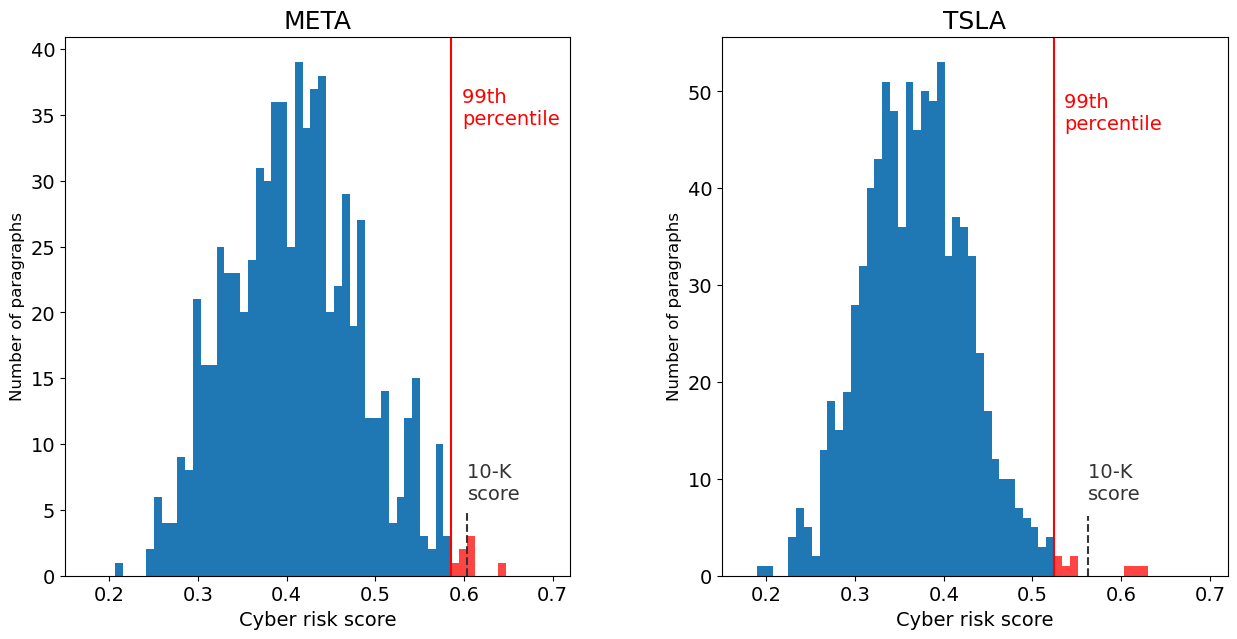

In [5]:
#plot the distribution of paragraph scores
max__ = pd.DataFrame(max_, index = ['META', 'TSLA']).T
ax = max__.hist(bins = 50, figsize = (15,7))

#add lines and text at the 99th percentile
ax[0][0].axvline(max__.quantile(0.99).META+0.002, color = 'red')
ax[0][0].text(max__.quantile(0.99).META+0.015, ax[0][0].get_ylim()[1]-7, '99th \npercentile', color='red',
              ha='left', va='bottom', fontsize=14)
ax[0][1].axvline(max__.quantile(0.99).TSLA+0.004, color = 'red')
ax[0][1].text(max__.quantile(0.99).TSLA+0.015, ax[0][1].get_ylim()[1]-10, '99th \npercentile', color='red',
              ha='left', va='bottom', fontsize=14)

#make the boxes above the 99th percentile red
for patch in ax[0][0].patches:
    #patch.set_edgecolor('#000000')
    #patch.set_linewidth(0.5)
    if patch.get_x() >= max__.quantile(0.99).META:
        patch.set_facecolor('#FF4444')
        

for patch in ax[0][1].patches:
    #patch.set_edgecolor('#000000')
    #patch.set_linewidth(0.5)
    if patch.get_x() >= max__.quantile(0.99).TSLA:
        patch.set_facecolor('#FF4444')
        
#add the 10-K scores
scores = max__[max__>= max__.quantile(0.99)].mean()
ax[0][0].axvline(scores.META, ymin = 0, ymax = 0.12, color = (0.2, 0.2, 0.2), linestyle = '--')
ax[0][0].text(scores.META, 5.5, '10-K \nscore', color=(0.2, 0.2, 0.2), ha='left', va='bottom', fontsize=14)
ax[0][1].axvline(scores.TSLA, ymin = 0, ymax = 0.11, color = (0.2, 0.2, 0.2), linestyle = '--')
ax[0][1].text(scores.TSLA, 7.5, '10-K \nscore', color=(0.2, 0.2, 0.2), ha='left', va='bottom', fontsize=14)

#set the font sizes
ax[0][0].set_title('META',fontsize = 18)
ax[0][1].set_title('TSLA',fontsize = 18)
ax[0][0].tick_params(axis = 'x', labelsize = 14)
ax[0][0].tick_params(axis = 'y', labelsize = 14)
ax[0][1].tick_params(axis = 'x', labelsize = 14)
ax[0][1].tick_params(axis = 'y', labelsize = 14)
ax[0][0].set_xlabel('Cyber risk score', fontsize = 14)
ax[0][1].set_xlabel('Cyber risk score', fontsize = 14)

#suppress the grid
ax[0][0].grid(False)
ax[0][1].grid(False)

#set x axis
ax[0][0].set_xlim((0.15,0.72))
ax[0][1].set_xlim((0.15,0.72))

#add y labels
ax[0][0].set_ylabel('Number of paragraphs', fontsize = 12)
ax[0][1].set_ylabel('Number of paragraphs', fontsize = 12)

plt.show()

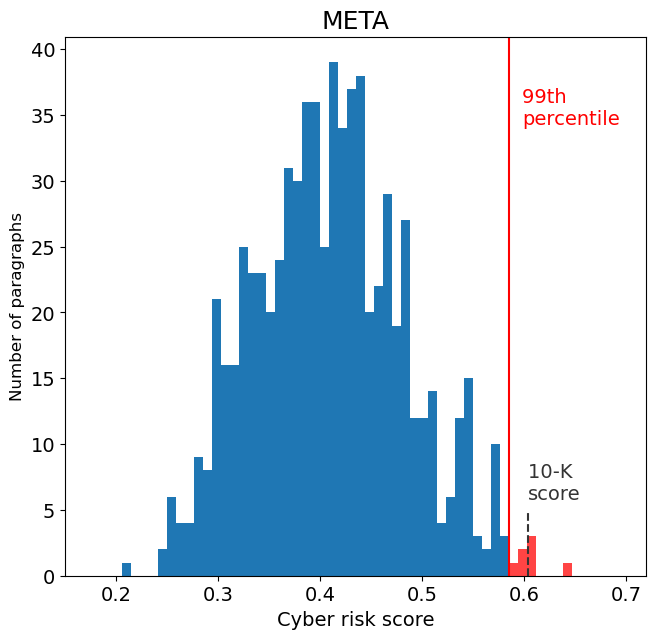

In [17]:
#plot the distribution of paragraph scores
max__ = pd.DataFrame(max_, index = ['META', 'TSLA']).T
ax = max__.META.hist(bins = 50, figsize = (7.5,7))

#add lines and text at the 99th percentile
ax.axvline(max__.quantile(0.99).META+0.002, color = 'red')
ax.text(max__.quantile(0.99).META+0.015, ax.get_ylim()[1]-7, '99th \npercentile', color='red',
        ha='left', va='bottom', fontsize=14)

#make the boxes above the 99th percentile red
for patch in ax.patches:
    if patch.get_x() >= max__.quantile(0.99).META:
        patch.set_facecolor('#FF4444')
        
#add the 10-K scores
scores = max__[max__>= max__.quantile(0.99)].mean()
ax.axvline(scores.META, ymin = 0, ymax = 0.12, color = (0.2, 0.2, 0.2), linestyle = '--')
ax.text(scores.META, 5.5, '10-K \nscore', color=(0.2, 0.2, 0.2), ha='left', va='bottom', fontsize=14)

#set the font sizes
ax.set_title('META',fontsize = 18)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_xlabel('Cyber risk score', fontsize = 14)

#suppress the grid
ax.grid(False)

#set x axis
ax.set_xlim((0.15,0.72))

#add y labels
ax.set_ylabel('Number of paragraphs', fontsize = 12)

plt.show()

In [73]:
#print the highest scoring paragraphs from META
META_idxs = max__.META.sort_values(ascending = False).index[:5]
META_tokens = pd.read_csv('../data/10k_statements/tokens/2022/META_tokens.csv.gz', index_col = 0).T[META_idxs]
for c in META_tokens.columns:
    print(f'META paragraph {c}:')
    print(' '.join(META_tokens[c].dropna()))
    print(f'Len = {len(META_tokens[c].dropna())} words')
    print('\n')

print('-'*115)
#print the highest scoring paragraphs from TSLA
TSLA_idxs = max__.TSLA.sort_values(ascending = False).index[:5]
TSLA_tokens = pd.read_csv('../data/10k_statements/tokens/2022/TSLA_tokens.csv.gz', index_col = 0).T[TSLA_idxs]
for c in TSLA_tokens.columns:
    print(f'TSLA paragraph {c}:')
    print(' '.join(TSLA_tokens[c].dropna()))
    print(f'Len = {len(TSLA_tokens[c].dropna())} words')
    print('\n')

META paragraph 348:
errors bugs vulnerabilities inherently may difficult detect may discovered code released external internal use example september announced discovery third party cyber attack exploited vulnerability facebook code steal user access tokens access certain profile information user accounts facebook
Len = 37 words


META paragraph 335:
addition third parties may attempt fraudulently induce employees users disclose information order gain access data users data cyber attacks continue evolve sophistication volume inherently may difficult detect long periods
Len = 29 words


META paragraph 340:
incidents efforts remediate incidents may result decline active user base engagement levels events material adverse effect business reputation financial results example september announced discovery third party cyber attack exploited vulnerability facebook code steal user access tokens used access certain profile information approximately million user accounts facebook
Len = 46 words



# Using old MITRE

## Training

In [46]:
#read in the tokens from the 10-K statements
training_years = [2007]
tokens_10k = []
for year in training_years:
    path_tokens = glob.glob('../data/10k_statements/tokens/{}/*'.format(year))
    for path in tqdm(path_tokens, desc = 'Reading in tokens for {}'.format(year), leave = False):
        df = pd.read_csv(path, index_col = 0, dtype = 'object')
        tokens = df.stack().groupby(level = 0).agg(list).values
        ticker = re.findall('{}/(.*)_tokens'.format(year),path)[0]
        tokens_10k.append(tokens)

#add a tag to each paragraph
tagged_tokens = []
tag_links = []
training_tokens = []
for i, tokens_per_line in enumerate(tqdm(tokens_10k, desc = 'Adding tags to 10-Ks', leave = False)):
    for j, tokens in enumerate(tokens_per_line):
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['10kt{}_{}'.format(i,j)]))
        tag_links.append('10kt{}_{}'.format(i,j))
        training_tokens.append(tokens)

print('Nb training paragraphs from 10-Ks: {}'.format(len(tagged_tokens))) 

#add MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/old_descriptions/tactics*')
for i,type_ in enumerate(tqdm(tactic_types, desc = 'Adding Tactics', leave = False)):
    tactics = pd.read_csv(type_, index_col = [0])
    for j,tactic in enumerate(tactics.Description.values):
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['tac{}_{}'.format(i,j)]))
        tag_links.append('tac{}_{}'.format(i,j))
        training_tokens.append(tokens)

print('Nb training paragraphs: {}'.format(len(tagged_tokens)))

#this dataframe links the numerical index of each training sentence to it's tag
pd.DataFrame(tag_links, columns = ['tag']).to_csv('../data/index_to_tags.csv')

Reading in tokens for 2008:   0%|          | 0/3366 [00:00<?, ?it/s]

Adding tags to 10-Ks:   0%|          | 0/3366 [00:00<?, ?it/s]

Nb training paragraphs from 10-Ks: 1822093


Adding Tactics:   0%|          | 0/10 [00:00<?, ?it/s]

Nb training paragraphs: 1822255


In [65]:
path_tokens = glob.glob('../data/10k_statements/tokens/{}/*'.format(2007))
len(path_tokens)

3301

In [47]:
#useful to show the logs when training the model
logging.disable(logging.NOTSET)
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

In [48]:
model_ = 'model_dbow_v200_e50_w15'


v_size = int(re.findall('v(\d+)', model_)[0])
epochs = int(re.findall('e(\d+)', model_)[0])
dm = int(bool(re.search('dm', model_)))
window = int(re.findall('w(\d+)', model_)[0])

#define the model and vocabulary
model = gensim.models.doc2vec.Doc2Vec(vector_size = v_size, min_count = 5, epochs = epochs, sample = 1e-5,
                                      negative = 5, dm = dm, window = window)
model.build_vocab(tagged_tokens)

#train the model
model.random.seed(0)
model.train(tagged_tokens, total_examples = model.corpus_count, epochs = model.epochs)

#save the model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/old_Doc2vec/{}'.format(model_))
model.save(path)

clear_output()

## Computing the paragraph vectors

In [49]:
token_path = '../data/10k_statements/tokens/{}/*'
save_path = '../data/10k_statements/old_paragraph_vectors/'
years = [2022]#np.arange(2016,2023)
model_ = 'model_dbow_v200_e50_w15'

#Save the vectors for all firm-year observations
for year in years:
    files = glob.glob(token_path.format(year))
    #load the previously saved model
    path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/old_Doc2vec/'+model_)
    model = gensim.models.doc2vec.Doc2Vec.load(path)

    for i,file in enumerate(tqdm(files, desc = f'Vectorizing paragraphs for {year}', leave = False)):
        ticker = re.findall('\d/(.*)_tokens.csv.gz', file)[0]
        tockens = pd.read_csv(file, index_col = 0, dtype = 'object').T

        vects = []
        sentences = []
        for j, col in enumerate(tockens.columns):
            v = get_vect(model, tockens[col].dropna().values, '10k{}_{}'.format(0,j))
            vects.append(v)
        
        vects = pd.DataFrame(vects)
        vects.to_csv(save_path+'{}/{}_vectors.csv.gz'.format(year, ticker), index = False)

clear_output()
print('Done')

Done


## Computing the cybersecurity risk measure

In [50]:
vector_path = '../data/10k_statements/paragraph_vectors/{}/*'
save_path = '../data/cyber_risk_measures/old_doc2vec/'
years = [2022]#np.arange(2016,2023)
model_ = 'model_dbow_v200_e50_w15'

#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/old_Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)
#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/old_descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

document_scores = []
document_tactic_scores = []

#compute the cybersecurity risk measure
for year in years:
    files = glob.glob(vector_path.format(year))
    vects = []
    tickers = []
    doc_scores = {}
    doc_tactic_scores = {}
    for file in tqdm(files, desc = f'Computing cyber-risk measure for {year}', leave = False):
        ticker = re.findall('\d/(.*)_vectors.csv.gz', file)[0]
        try:
            vects = pd.read_csv(file).values
        except:
            continue
        doc_tactic_scores[ticker] = []
        
        if not len(vects):
            continue
        
        #compute the similarity for all vectors
        sim = []
        for v in vects:
            sim.append(fast_sim(v, vec_tac))
        
        #save the scores (= mean score above 99th percentile of scores of the paragraphs)
        max_ = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph
        doc_scores[ticker] = np.mean(max_[max_>= np.percentile(max_, 99)])
        #get a score for each type of cybersecurity event
        sim = np.array(sim)
        for type_ in np.unique(type_table):
            #get the score for the tactic
            max_by_tactic = np.max(sim[:,type_table == type_], axis = 1)
            doc_tactic_scores[ticker].append(np.mean(max_by_tactic[max_by_tactic >= np.percentile(max_by_tactic, 99)]))
        
    document_scores.append(doc_scores)
    document_tactic_scores.append(doc_tactic_scores)
    
#save general cybersecurity scores
document_scores_df = pd.DataFrame(document_scores, index = years)
document_scores_df.to_csv(save_path + 'general_cybersec_scores.csv.gz')

#save scores by tactic
document_tactic_scores_df = pd.DataFrame(document_tactic_scores, index = years)
for year in years:
    document_tactic_scores_df.loc[year] = document_tactic_scores_df.loc[year].apply(lambda x: [np.nan]*len(np.unique(type_table)) if pd.Series(x).isna().all() else x)
mux = pd.MultiIndex.from_product([document_tactic_scores_df.columns,np.unique(type_table)])
data = np.vstack([np.concatenate(entry) for entry in document_tactic_scores_df.to_numpy()])
document_tactic_scores_df = pd.DataFrame(data, index = years, columns = mux)
document_tactic_scores_df.columns = document_tactic_scores_df.columns.swaplevel(0, 1)
document_tactic_scores_df.sort_index(axis=1, level=0, inplace=True)
document_tactic_scores_df.to_csv(save_path + 'tactic_cybersec_scores.csv.gz')

clear_output()
print('Done')

Done


In [52]:
model_ = 'model_dbow_v200_e50_w15'
#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/old_Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)


#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/old_descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

max_ = []
files = ['../data/10k_statements/paragraph_vectors/2022/META_vectors.csv.gz',
         '../data/10k_statements/paragraph_vectors/2022/TSLA_vectors.csv.gz']
for file in files:
    vects = pd.read_csv(file).values
    #compute the similarity for all vectors
    sim = []
    for v in vects:
        sim.append(fast_sim(v, vec_tac))
    max_.append(np.max(sim, axis = 1)) #consider the maximum similarity for each paragraph
    
clear_output()

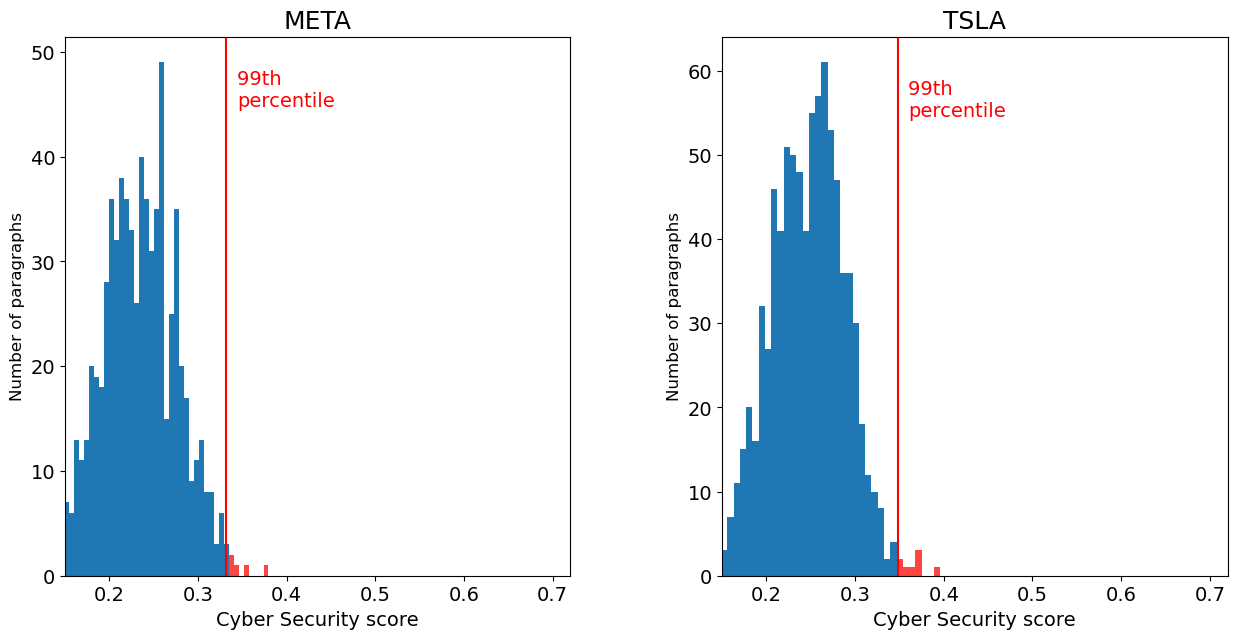

In [53]:
#plot the distribution of paragraph scores
max__ = pd.DataFrame(max_, index = ['META', 'TSLA']).T
ax = max__.hist(bins = 50, figsize = (15,7))

#add lines and text at the 99th percentile
ax[0][0].axvline(max__.quantile(0.99).META+0.002, color = 'red')
ax[0][0].text(max__.quantile(0.99).META+0.015, ax[0][0].get_ylim()[1]-7, '99th \npercentile', color='red',
              ha='left', va='bottom', fontsize=14)
ax[0][1].axvline(max__.quantile(0.99).TSLA+0.004, color = 'red')
ax[0][1].text(max__.quantile(0.99).TSLA+0.015, ax[0][1].get_ylim()[1]-10, '99th \npercentile', color='red',
              ha='left', va='bottom', fontsize=14)

#make the boxes above the 99th percentile red
for patch in ax[0][0].patches:
    #patch.set_edgecolor('#000000')
    #patch.set_linewidth(0.5)
    if patch.get_x() >= max__.quantile(0.99).META:
        patch.set_facecolor('#FF4444')
        

for patch in ax[0][1].patches:
    #patch.set_edgecolor('#000000')
    #patch.set_linewidth(0.5)
    if patch.get_x() >= max__.quantile(0.99).TSLA:
        patch.set_facecolor('#FF4444')

#set the font sizes
ax[0][0].set_title('META',fontsize = 18)
ax[0][1].set_title('TSLA',fontsize = 18)
ax[0][0].tick_params(axis = 'x', labelsize = 14)
ax[0][0].tick_params(axis = 'y', labelsize = 14)
ax[0][1].tick_params(axis = 'x', labelsize = 14)
ax[0][1].tick_params(axis = 'y', labelsize = 14)
ax[0][0].set_xlabel('Cyber Security score', fontsize = 14)
ax[0][1].set_xlabel('Cyber Security score', fontsize = 14)

#suppress the grid
ax[0][0].grid(False)
ax[0][1].grid(False)

#set x axis
ax[0][0].set_xlim((0.15,0.72))
ax[0][1].set_xlim((0.15,0.72))

#add y labels
ax[0][0].set_ylabel('Number of paragraphs', fontsize = 12)
ax[0][1].set_ylabel('Number of paragraphs', fontsize = 12)

plt.show()

In [54]:
max__.TSLA.sort_values(ascending = False)

769    0.396244
559    0.373172
774    0.371010
762    0.369817
554    0.367088
         ...   
249    0.136535
392    0.134610
594    0.128444
560    0.107279
590    0.042712
Name: TSLA, Length: 856, dtype: float64

In [60]:
pd.read_csv('../data/10k_statements/tokens/2022/TSLA_tokens.csv.gz', index_col = 0).iloc[762,:].dropna().values

array(['instances', 'guaranteed', 'payments', 'fund', 'investors',
       'specified', 'agreements', 'fund', 'creditors', 'recourse',
       'general', 'credit', 'funds'], dtype=object)

In [63]:
np.shape(vec_tac)

(162, 200)